In [28]:
import pandas as pd
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.anova import AnovaRM

In [29]:
data = pd.read_csv("Data/IN5060_fall24-during-study.csv")
data.rename(columns={
    'Session ID (the last session that the participant has completed)': 'SessionID',
    'Participant ID (top-right corner)': 'ParticipantID',
    'I felt bored': 'FeltBored',
    'I felt annoyed': 'FeltAnnoyed',
    'I felt excited': 'FeltExcited',
    'I felt at ease': 'FeltAtEase',
    'I felt satisfied': 'FeltSatisfied',
    'I felt curious': 'FeltCurious',
    'I felt stressed': 'FeltStressed',
    'I felt tired': 'FeltTired'
}, inplace=True)

data['SessionID'] = data['SessionID'].str.upper()

# Display all columns and expand display width
pd.set_option('display.max_columns', None)     # Show all columns
pd.set_option('display.width', 1000)           # Set the display width to fit large tables
pd.set_option('display.max_colwidth', None)    # Show full column content without truncation
pd.set_option('display.max_rows', None)        # Show all rows (remove this if there are too many rows)

In [ ]:
required_sessions = ['ALICE', 'ILLIAC', 'CYSP', 'VOYAGER']
# Dropping rows with SessionID values that are not in the required_sessions list
filtered_data = data[data['SessionID'].isin(required_sessions)]

# Step 3: Identify participants who have all four required sessions
participant_session_counts = filtered_data.groupby('ParticipantID')['SessionID'].apply(lambda x: sorted(x) == sorted(required_sessions))
valid_participants = participant_session_counts[participant_session_counts].index
final_data = filtered_data[filtered_data['ParticipantID'].isin(valid_participants)]

# Step 4: Reshape the data for ANOVA
# Convert to wide format for checking data structure and ensuring all participants have four sessions
wide_data = final_data.pivot(index='ParticipantID', columns='SessionID', values='FeltExcited').dropna()

# Convert to long format for AnovaRM compatibility
long_data = wide_data.reset_index().melt(id_vars='ParticipantID', var_name='SessionID', value_name='FeltExcited')

# Step 5: Run the repeated measures ANOVA
rm_anova = AnovaRM(long_data, depvar='FeltExcited', subject='ParticipantID', within=['SessionID'])
rm_anova_result = rm_anova.fit()

# Display the results
print(rm_anova_result.summary())

                 Anova
          F Value Num DF  Den DF  Pr > F
----------------------------------------
SessionID  5.7332 3.0000 219.0000 0.0009



We wanted to see if participants’ "FeltExcited" levels changed significantly across four different sessions: ILLIAC, CYSP, VOYAGER, and ALICE.
The repeated measures ANOVA is suitable here because each participant rated their excitement multiple times, once in each session. This method accounts for the dependency between these repeated measures.

- F-value: This is the statistic calculated by the ANOVA test. Higher values suggest that the variation in "FeltExcited" across sessions is greater than what we’d expect by random chance.
p-value: The p-value tells us the probability that this result could have occurred by chance. Here, 
𝑝
=
0.0009
p=0.0009, which is less than the typical threshold (0.05), so we reject the null hypothesis. This means there is a significant difference in "FeltExcited" scores across the sessions.

We conducted a one-way repeated measures ANOVA (also called a one-way within-subjects ANOVA) because:

One-way: We analyzed the effect of a single factor, which is SessionID, on the "FeltExcited" variable.
Repeated Measures: Each participant provided excitement scores for all four sessions, making the data "within-subjects" (each participant serves as their own control across conditions).
The ANOVA assessed whether "FeltExcited" significantly differed across the four SessionIDs, treating each SessionID as a separate level of the single independent variable.

In [57]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Performing Tukey's HSD post-hoc test for one-way repeated measures ANOVA
# Tukey's test requires the data to be in long format with "SessionID" as the grouping factor
tukey_result = pairwise_tukeyhsd(endog=long_data['FeltExcited'], groups=long_data['SessionID'], alpha=0.05)

# Displaying the results
tukey_result.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
ALICE,CYSP,-0.2432,0.5619,-0.7257,0.2392,False
ALICE,ILLIAC,-0.1622,0.8211,-0.6446,0.3203,False
ALICE,VOYAGER,-0.5811,0.0109,-1.0635,-0.0987,True
CYSP,ILLIAC,0.0811,0.9725,-0.4013,0.5635,False
CYSP,VOYAGER,-0.3378,0.2709,-0.8203,0.1446,False
ILLIAC,VOYAGER,-0.4189,0.114,-0.9013,0.0635,False


To interpret Tukey’s HSD (Honestly Significant Difference) test results, you’ll look at specific elements that indicate whether each pair of groups (here, SessionIDs) significantly differs in "FeltExcited" scores. Here’s how to interpret the table:

Key Columns in Tukey’s HSD Output
Group1 and Group2: These columns list each pair of SessionIDs being compared (e.g., ILLIAC vs CYSP).

Mean Difference: The average difference in "FeltExcited" scores between the two SessionIDs. A larger mean difference suggests a greater disparity in excitement levels between tasks.

p-Adjusted: The adjusted p-value for the comparison. If this value is below 0.05, it indicates a significant difference in excitement between the two SessionIDs.

Lower and Upper Bound of Confidence Interval: These give the range of values within which the true mean difference likely falls. If this interval does not include zero, it suggests a statistically significant difference.

Reject: This column indicates whether the difference is statistically significant. A “True” in this column means the difference between the two SessionIDs is significant.

Interpreting Each Row
Significant Difference (p < 0.05): If Reject is “True,” the excitement levels for those two sessions are significantly different.
Non-Significant Difference (p >= 0.05): If Reject is “False,” there’s no significant difference between the sessions.
Example Interpretation
If ILLIAC vs VOYAGER shows:

Mean Difference: 1.2 (meaning on average, VOYAGER had higher excitement by 1.2 points than ILLIAC)
p-Adjusted: 0.02 (significant since it's less than 0.05)
Reject: True (indicating a significant difference)
This means that ILLIAC and VOYAGER have significantly different excitement levels, with VOYAGER generally eliciting higher excitement.

Let me know if you’d like help comparing the significant pairs here with those from the Friedman’s post-hoc!

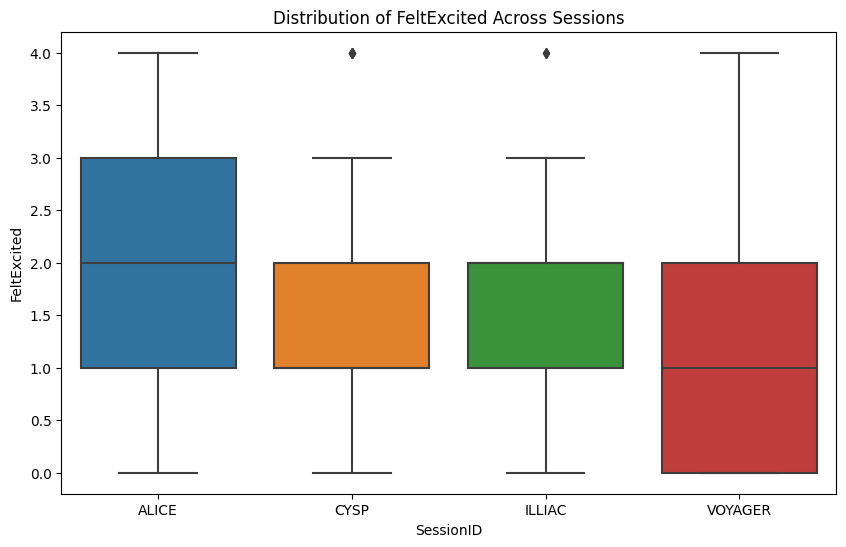

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting boxplots for "FeltExcited" with SessionID as the hue
plt.figure(figsize=(10, 6))
sns.boxplot(data=long_data, x='SessionID', y='FeltExcited')
plt.title('Distribution of FeltExcited Across Sessions')
plt.xlabel('SessionID')
plt.ylabel('FeltExcited')
plt.show()

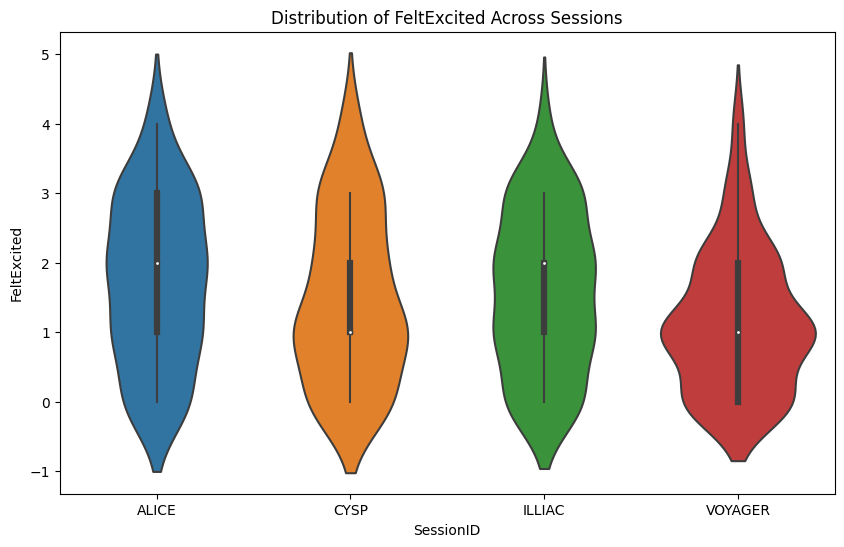

In [33]:
# Plotting violin plots for "FeltExcited" across each SessionID
plt.figure(figsize=(10, 6))
sns.violinplot(data=long_data, x='SessionID', y='FeltExcited')
plt.title('Distribution of FeltExcited Across Sessions')
plt.xlabel('SessionID')
plt.ylabel('FeltExcited')
plt.show()


In [55]:
# Performing Friedman's test as a non-parametric alternative to the one-way repeated measures ANOVA
from scipy.stats import friedmanchisquare

# Extracting "FeltExcited" scores for each SessionID and organizing them into columns for Friedman's test
session_data = [long_data[long_data['SessionID'] == session]['FeltExcited'].values for session in required_sessions]

# Running Friedman's test
friedman_test = friedmanchisquare(*session_data)

# Displaying the results
friedman_test


FriedmanchisquareResult(statistic=14.229729729729895, pvalue=0.0026085567187358613)

In [56]:
# Performing a post-hoc analysis for Friedman's test using pairwise Wilcoxon signed-rank tests with Bonferroni correction
from scipy.stats import wilcoxon
import itertools
import pandas as pd

# Pairwise comparisons between each pair of SessionIDs for "FeltExcited"
session_pairs = list(itertools.combinations(required_sessions, 2))
posthoc_results = {}

for pair in session_pairs:
    # Extract "FeltExcited" scores for the pair of sessions
    session1_data = long_data[long_data['SessionID'] == pair[0]]['FeltExcited'].values
    session2_data = long_data[long_data['SessionID'] == pair[1]]['FeltExcited'].values
    
    # Perform Wilcoxon signed-rank test for the pair
    stat, p_value = wilcoxon(session1_data, session2_data)
    
    # Apply Bonferroni correction by multiplying the p-value by the number of comparisons
    corrected_p_value = min(p_value * len(session_pairs), 1)  # Ensure p-value does not exceed 1
    posthoc_results[f"{pair[0]} vs {pair[1]}"] = corrected_p_value

# Displaying post-hoc test results
posthoc_df = pd.DataFrame.from_dict(posthoc_results, orient='index', columns=['Corrected p-value'])
posthoc_df.sort_values(by='Corrected p-value', inplace=True)
posthoc_df


,Corrected p-value
ALICE vs VOYAGER,0.000363
CYSP vs VOYAGER,0.036564
ILLIAC vs VOYAGER,0.038541
ALICE vs CYSP,0.719201
ALICE vs ILLIAC,1.000000
ILLIAC vs CYSP,1.000000


The post-hoc analysis I ran is a pairwise Wilcoxon signed-rank test with Bonferroni correction. This method is commonly used for non-parametric post-hoc testing following Friedman’s test, where:

Wilcoxon Signed-Rank Test: A non-parametric alternative to the paired t-test, comparing two related samples. Here, it checks differences in "FeltExcited" scores between each pair of SessionIDs (task difficulties).

Bonferroni Correction: A statistical adjustment to control for multiple comparisons, reducing the likelihood of Type I errors (false positives). It adjusts the p-value threshold based on the number of tests (in this case, six comparisons).

This approach allows us to pinpoint specific SessionID pairs that differ significantly without relying on normality, which matches the assumptions underlying Friedman’s test.